In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os, pathlib, shutil, random

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import imdb
from tensorflow.keras import Sequential, Input, Model, layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, AveragePooling2D, TextVectorization
from tensorflow.keras.layers import Dense, Flatten, Softmax, Dropout, Embedding, SimpleRNN, LSTM, GRU, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, Rescaling, RandomWidth, RandomHeight, Lambda
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.metrics import geometric_mean_score
from sklearn.utils.class_weight import compute_class_weight

In [2]:
path = "C:/Users/Yakina/.cache/kagglehub/datasets/adisongoh/it-service-ticket-classification-dataset/versions/1/all_tickets_processed_improved_v3.csv"

In [3]:
df = pd.read_csv(path)
df.head()

,Document,Topic_group
0,connection with icon icon dear please setup ic...,Hardware
1,work experience user work experience user hi w...,Access
2,requesting for meeting requesting meeting hi p...,Hardware
3,reset passwords for external accounts re expir...,Access
4,mail verification warning hi has got attached ...,Miscellaneous


In [4]:
df['Topic_group'].unique()

array(['Hardware', 'Access', 'Miscellaneous', 'HR Support', 'Purchase',
       'Administrative rights', 'Storage', 'Internal Project'],
      dtype=object)

In [5]:
df.isnull().any()

Document       False
Topic_group    False
dtype: bool

In [6]:
df[df.duplicated()]

,Document,Topic_group


In [7]:
label_encoder = LabelEncoder()
df['Topic_group'] = label_encoder.fit_transform(df['Topic_group']).astype('int32')
label_encoder.classes_

array(['Access', 'Administrative rights', 'HR Support', 'Hardware',
       'Internal Project', 'Miscellaneous', 'Purchase', 'Storage'],
      dtype=object)

In [8]:
df

,Document,Topic_group
0,connection with icon icon dear please setup ic...,3
1,work experience user work experience user hi w...,0
2,requesting for meeting requesting meeting hi p...,3
3,reset passwords for external accounts re expir...,0
4,mail verification warning hi has got attached ...,5
...,...,...
47832,git space for a project issues with adding use...,0
47833,error sent july error hi guys can you help out...,5
47834,connection issues sent tuesday july connection...,3
47835,error cube reports sent tuesday july error hel...,2


In [9]:
df.rename(columns={'Document': 'x', 'Topic_group': 'y'}, inplace=True)

train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['y'])
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42, stratify=train_val_df['y'])
train_df.shape, val_df.shape, test_df.shape

((30615, 2), (7654, 2), (9568, 2))

In [10]:
train_ds = tf.data.Dataset.from_tensor_slices((train_df['x'].values, train_df['y'].values))
val_ds = tf.data.Dataset.from_tensor_slices((val_df['x'].values, val_df['y'].values))
test_ds = tf.data.Dataset.from_tensor_slices((test_df['x'].values, test_df['y'].values))

batch_size = 32
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

print(type(train_ds), type(val_ds), type(test_ds))

<class 'tensorflow.python.data.ops.batch_op._BatchDataset'> <class 'tensorflow.python.data.ops.batch_op._BatchDataset'> <class 'tensorflow.python.data.ops.batch_op._BatchDataset'>


In [11]:
text_only_train_ds = train_ds.map(lambda x, y: x)

In [12]:
max_length = 500
max_tokens = 20000

text_vectorization = TextVectorization(
    max_tokens=max_tokens,
    output_mode="tf_idf",
)

text_vectorization.adapt(text_only_train_ds)

int_train_ds_tfidf = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds_tfidf = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds_tfidf = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

In [13]:
vocabulary = text_vectorization.get_vocabulary()
# vocabulary

In [15]:
max_length = 500
max_tokens = 20000

text_vectorization = TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

In [16]:
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


In [17]:
max_length = 500
max_tokens = 20000

text_vectorization = TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

In [18]:
embedding_dim = 100
max_tokens = 20000

vocabulary = text_vectorization.get_vocabulary()

word_index = dict(zip(vocabulary, range(len(vocabulary))))

embedding_matrix = np.zeros((max_tokens, embedding_dim))

for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [19]:
embedding_layer = Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

In [20]:
y_values = np.concatenate([y.numpy() for y in int_train_ds.map(lambda x, y: y)])
unique_classes, class_counts = np.unique(y_values, return_counts=True)
for label, count in zip(unique_classes, class_counts):
    print(f"Ticket {label}: {count} samples")

Ticket 0: 4560 samples
Ticket 1: 1126 samples
Ticket 2: 6986 samples
Ticket 3: 8714 samples
Ticket 4: 1356 samples
Ticket 5: 4518 samples
Ticket 6: 1577 samples
Ticket 7: 1778 samples


In [21]:
np.concatenate([x.numpy() for x in int_train_ds.map(lambda x, y: x)])

array([[  43,   65,  848, ...,    0,    0,    0],
       [1213,  144,   16, ...,    0,    0,    0],
       [1195,   16,   49, ...,    0,    0,    0],
       ...,
       [1224,   16,   28, ...,    0,    0,    0],
       [  54,   17,   12, ...,    0,    0,    0],
       [  72, 1620,  213, ...,    0,    0,    0]], dtype=int64)

In [22]:
from imblearn.over_sampling import SMOTE
X_train = np.concatenate([x.numpy() for x in int_train_ds.map(lambda x, y: x)])
y_train = np.concatenate([y.numpy() for y in int_train_ds.map(lambda x, y: y)])

X_train_reshaped = X_train.reshape((X_train.shape[0], -1))

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_reshaped, y_train)

X_train_resampled = X_train_resampled.reshape((-1, max_length, 1))

resampled_train_ds = tf.data.Dataset.from_tensor_slices((X_train_resampled, y_train_resampled))

batch_size = 32
resampled_train_ds = resampled_train_ds.batch(batch_size)

In [23]:
y_values = np.concatenate([y.numpy() for y in resampled_train_ds.map(lambda x, y: y)])
unique_classes, class_counts = np.unique(y_values, return_counts=True)
for label, count in zip(unique_classes, class_counts):
    print(f"Ticket {label}: {count} samples")

Ticket 0: 8714 samples
Ticket 1: 8714 samples
Ticket 2: 8714 samples
Ticket 3: 8714 samples
Ticket 4: 8714 samples
Ticket 5: 8714 samples
Ticket 6: 8714 samples
Ticket 7: 8714 samples


In [24]:
gru_model = Sequential([
    embedding_layer,
    GRU(units = 64, input_shape = (None, 500)),
    Dense(units = 8, activation = 'softmax')
])
gru_model.compile(optimizer = 'RMSprop',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

gru_class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(train_df['y']), y = train_df['y'])
gru_class_weights_dict = dict(enumerate(gru_class_weights))

gru_history = gru_model.fit(int_train_ds, epochs = 10,
          class_weight = gru_class_weights_dict,
          validation_data = int_val_ds)

c:\Users\Yakina\anaconda3\envs\traineeship\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
957/957 ━━━━━━━━━━━━━━━━━━━━ 398s 407ms/step - accuracy: 0.3534 - loss: 1.5246 - val_accuracy: 0.6676 - val_loss: 0.9652
Epoch 2/10
957/957 ━━━━━━━━━━━━━━━━━━━━ 342s 357ms/step - accuracy: 0.6939 - loss: 0.7125 - val_accuracy: 0.7533 - val_loss: 0.7345
Epoch 3/10
957/957 ━━━━━━━━━━━━━━━━━━━━ 450s 471ms/step - accuracy: 0.7695 - loss: 0.5260 - val_accuracy: 0.7855 - val_loss: 0.6225
Epoch 4/10
957/957 ━━━━━━━━━━━━━━━━━━━━ 309s 323ms/step - accuracy: 0.8006 - loss: 0.4415 - val_accuracy: 0.8090 - val_loss: 0.5652
Epoch 5/10
957/957 ━━━━━━━━━━━━━━━━━━━━ 245s 256ms/step - accuracy: 0.8191 - loss: 0.3900 - val_accuracy: 0.8192 - val_loss: 0.5241
Epoch 6/10
957/957 ━━━━━━━━━━━━━━━━━━━━ 284s 297ms/step - accuracy: 0.8346 - loss: 0.3503 - val_accuracy: 0.8260 - val_loss: 0.5020
Epoch 7/10
957/957 ━━━━━━━━━━━━━━━━━━━━ 1160s 1s/step - accuracy: 0.8454 - loss: 0.3179 - val_accuracy: 0.8307 - val_loss: 0.4967
Epoch 8/10
957/957 ━━━━━━━━━━━━━━━━━━━━ 256s 267ms/step - accuracy: 0.8553 - l

In [25]:
gru_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 500, 100)       │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │        31,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,064,786 (7.88 MB)

 Trainable params: 32,392 (126.53 KB)

 Non-trainable params: 2,000,000 (7.63 MB)

 Optimizer params: 32,394 (126.54 KB)

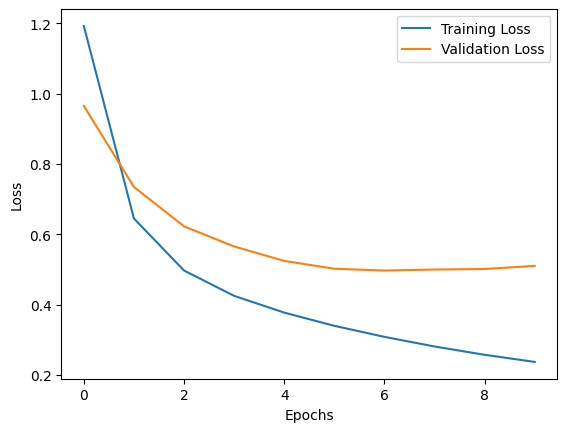

In [26]:
plt.plot(gru_history.history['loss'], label='Training Loss')
plt.plot(gru_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

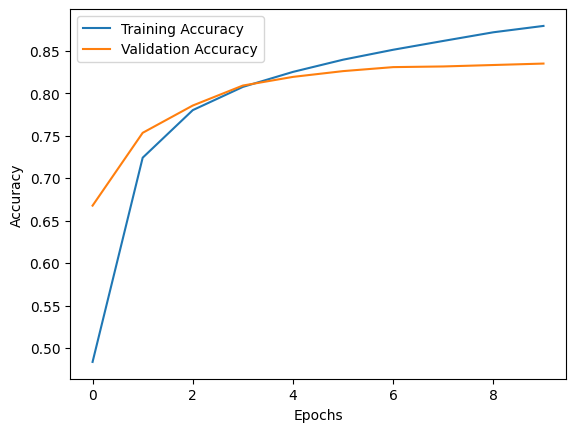

In [27]:
plt.plot(gru_history.history['accuracy'], label='Training Accuracy')
plt.plot(gru_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [28]:
loss, accuracy = gru_model.evaluate(int_test_ds)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

299/299 ━━━━━━━━━━━━━━━━━━━━ 24s 80ms/step - accuracy: 0.8378 - loss: 0.4962
Test Loss: 0.5004146099090576
Test Accuracy: 0.8352842926979065


In [29]:
y_pred = gru_model.predict(int_test_ds)

y_hat = []

for i in range(9568) :
  y_hat.append(np.argmax(y_pred[i]))

f1 = f1_score(test_df['y'], y_hat, average = 'weighted')

print("F1 Score :", f1)

299/299 ━━━━━━━━━━━━━━━━━━━━ 23s 75ms/step
F1 Score : 0.8358300324591957


In [33]:
import torch 
torch.save(gru_model, 'model.pth')

In [34]:
gru_model.save('model.h5')